<a href="https://colab.research.google.com/github/BEMiklos/PlantTraits2024/blob/main/Inferences_and_ensamble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import torch
from torch import nn
import torch.nn.functional as F

In [35]:
from torch.optim.lr_scheduler import OneCycleLR
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Model

In [ ]:
checkpoint_path = '/content/drive/MyDrive/best_model.pth.tar'

In [ ]:
class PlantTraitsPretrainedVisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = models.vit_b_16(pretrained=True)

    self.network.heads.head = nn.Linear(self.network.heads.head.in_features, 6, bias=True)

  def forward(self, xb):
    return self.network(xb)


In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model =
model = model.to(device)
model


In [ ]:

model =PlantTraitsPretrainedVisionTransformer()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 71.6MB/s]


In [ ]:
def load_checkpoint(checkpoint_file, model, optimizer, scheduler, device):
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return checkpoint['epoch']

#Dataset

In [3]:
!pip install -q kaggle

In [4]:

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c planttraits2024

100% 3.17G/3.17G [00:34<00:00, 188MB/s]
100% 3.17G/3.17G [00:34<00:00, 99.8MB/s]


In [6]:

!unzip -q '/content/planttraits2024.zip'

In [36]:

import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [37]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
random_state = 7

np.random.seed(0)

random.seed(0)

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [38]:
from torch.utils.data import Dataset, ConcatDataset, DataLoader, Subset, random_split

In [10]:



import albumentations as A
import cv2

In [11]:

TRAIN_IMAGES_PATH = '/content/train_images'
TEST_IMAGES_PATH = '/content/test_images'


In [12]:

mean_pattern = r'X\d+_mean'
sd_pattern = r'X\d+_sd'

In [13]:

def find_matching_elements(lst,pattern):
    matching_elements = [element for element in lst if re.search(pattern, element)]
    return matching_elements

In [14]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [15]:
def split_dataframe(train_df, test_df, train_size=0.8, val_size=0.2):
    if train_size + val_size != 1:
        raise ValueError("train_size, val_size, and test_size must sum to 1")

    train_df, val_df = train_test_split(train_df, train_size=train_size, random_state=random_state)
    return train_df, val_df, test_df

In [16]:
class AlbumentationsTransform:
    def __init__(self, augmentation):
        self.augmentation = augmentation

    def __call__(self, img):
        img_np = np.array(img)
        augmented = self.augmentation(image=img_np)
        return augmented['image']

train_augmentation =A.Compose([
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
          A.Rotate(limit=45, p=0.5),
          A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
          A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
          A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=2, fill_value=0, p=0.5),
          A.Sharpen(alpha=0.3, lightness=0.3, p=0.5),
          A.Resize(224, 224)
        ])
# train_augmentation = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.Rotate(limit=45, p=0.5),
#     A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
#     # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.2),
#     # A.ElasticTransform(alpha=1, sigma=15, alpha_affine=15, p=0.2),
#     # A.GaussianBlur(blur_limit=3, p=0.5),
#     # A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
#     #A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=2, fill_value=0, p=0.5),
#     A.Sharpen(alpha=0.3, lightness=0.3, p=0.5),
#     # A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=3, shadow_dimension=50, p=0.5),
#     A.Resize(256, 256)
# ])

test_val_augmentation = A.Compose([
    A.Resize(224, 224) # ViT 224
])

final_transforms = transforms.Compose([
    AlbumentationsTransform(test_val_augmentation), #Ez miért kell?
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [17]:
class PlantTraits2024_Dataset(Dataset):
    def __init__(self, df, columns, images_path, augmentation=None,
                 transform=None, augment_times=1, metadata_columns=None,
                 augment_metadata=False,
                 metadata_augmentation_std=0.1, target = None):

        self.df = df
        self.columns = columns
        self.images_path = images_path
        self.augmentation = augmentation
        self.transform = transform
        self.augment_times = augment_times
        self.augment_metadata = augment_metadata
        self.metadata_augmentation_std = metadata_augmentation_std
        self.target = target

    def __len__(self):
        return len(self.df) * self.augment_times

    def __getitem__(self, idx) :
        original_idx = idx // self.augment_times
        id = self.df.iloc[original_idx, 0]
        image_path = f'{self.images_path}/{id}.jpeg'
        bgr_image = cv2.imread(image_path)
        image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        filtered_df = self.df[self.df['id'] == id].iloc[0]

        meta_data = torch.as_tensor(filtered_df[self.columns].to_numpy().astype(np.float64))

        if (self.augment_metadata):
          meta_data = self.augment_tabular_data(meta_data)

        if self.augmentation:
            image = AlbumentationsTransform(self.augmentation)(image)

        if self.transform:
            image = self.transform(image)

        # target
        #target_values = meta_data[self.target]
        #feature_values = meta_data[[col for col in meta_data.columns if col not in self.target]]
        return image, meta_data[:self.target[0]], meta_data[self.target[0]:]

    def augment_tabular_data(self, meta_data):
        noise = np.random.normal(0, self.metadata_augmentation_std, meta_data.shape)
        augmented_meta_data = meta_data # + noise
        return torch.as_tensor(augmented_meta_data, dtype=torch.float32)

    def get_original_image_and_metadata(self, idx):
        image_name = self.df.iloc[idx, 0]
        image_path = f'{self.images_path}/{image_name}.jpeg'
        bgr_image = cv2.imread(image_path)
        image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

        meta_data = self.df.iloc[idx][self.columns].to_numpy().astype(np.float64)
        meta_data = torch.tensor(meta_data, dtype=torch.float64)

        # target
        #target_values = meta_data[self.target]
        #feature_values = meta_data[[col for col in meta_data.columns if col not in self.target]]
        return image, meta_data[:self.target[0]], meta_data[self.target[0]:]

In [18]:
targets = [col for col in train_df.columns if col not in test_df.columns]
targets = targets[:6]
metadata_columns = [col for col in train_df.columns if col in test_df.columns and col != 'id']

In [19]:
def create_dataset(train_df, test_df, columns, targets, train_images_path, test_images_path, augment_times, train_augmentation):
    # A képeknek csak a 10% át vesszük, hogy le tudjon futni Colabon a tanítás!!!
    train_df, val_df, test_df = split_dataframe(train_df.sample(frac=0.1, random_state=1), test_df)
    target = [i-1 for i, col in enumerate(train_df.columns) if col not in test_df.columns]
    target = target[:6]
    train_dataset = PlantTraits2024_Dataset(train_df, columns + targets, train_images_path, augmentation=train_augmentation, transform=final_transforms, augment_times=augment_times, augment_metadata=True,target=target)
    val_dataset = PlantTraits2024_Dataset(val_df, columns + targets, train_images_path, augmentation=test_val_augmentation, transform=final_transforms, augment_times=1, target=target)
    test_dataset = PlantTraits2024_Dataset(test_df, columns, test_images_path, augmentation=test_val_augmentation, transform=final_transforms, augment_times=1, target=target)

    return train_dataset, val_dataset, test_dataset

In [20]:
train_dataset, val_dataset, test_dataset = create_dataset(train_df, test_df, metadata_columns, targets, TRAIN_IMAGES_PATH, TEST_IMAGES_PATH, augment_times=2, train_augmentation=train_augmentation)

In [21]:
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size= 16, shuffle=False)

In [23]:
import seaborn as sns

# Investigate the distributions of test and train data

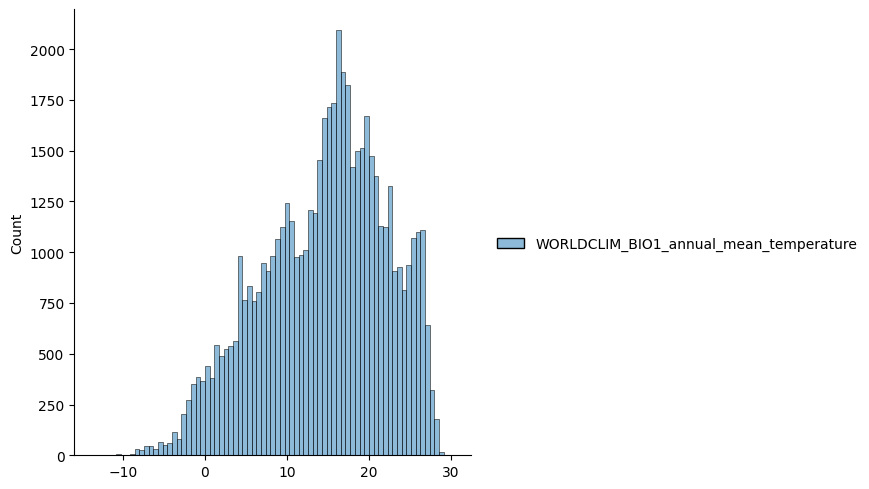

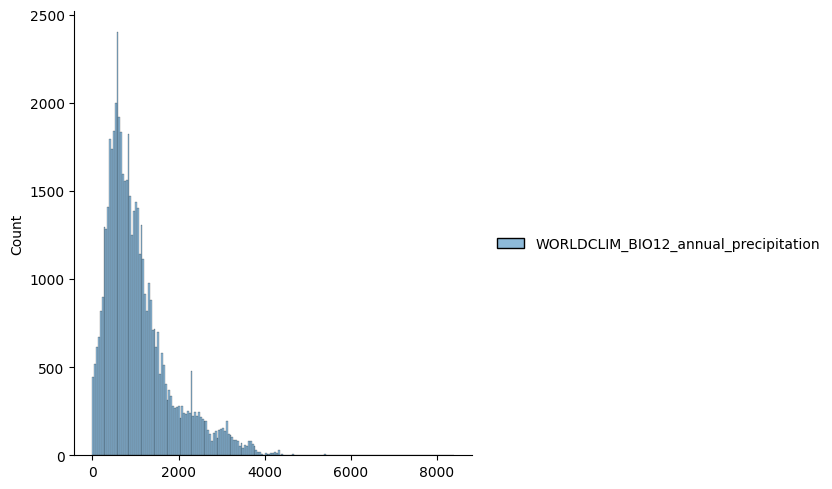

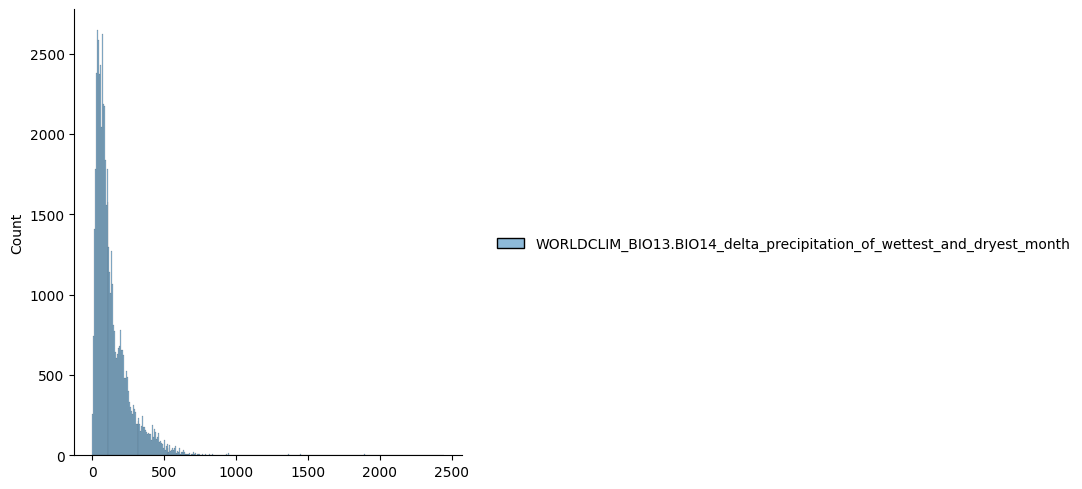

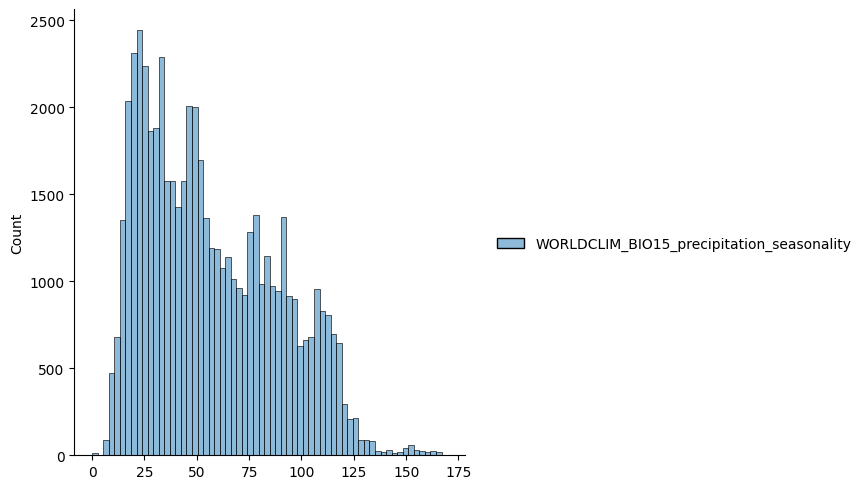

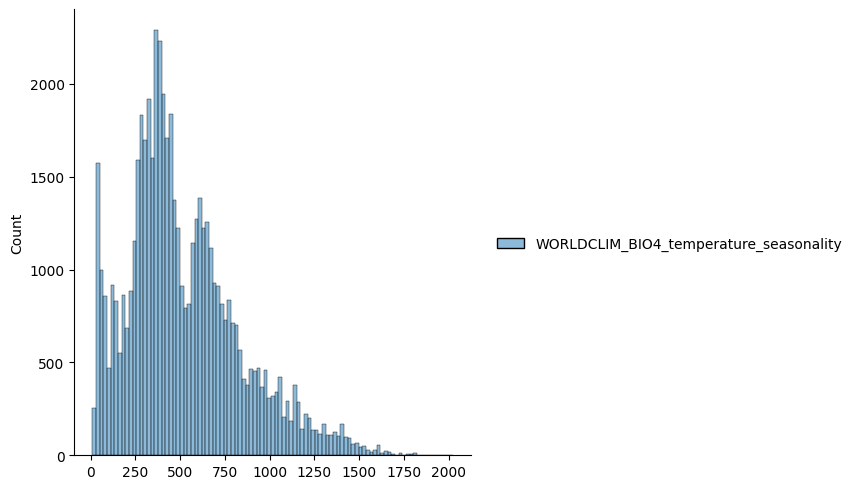

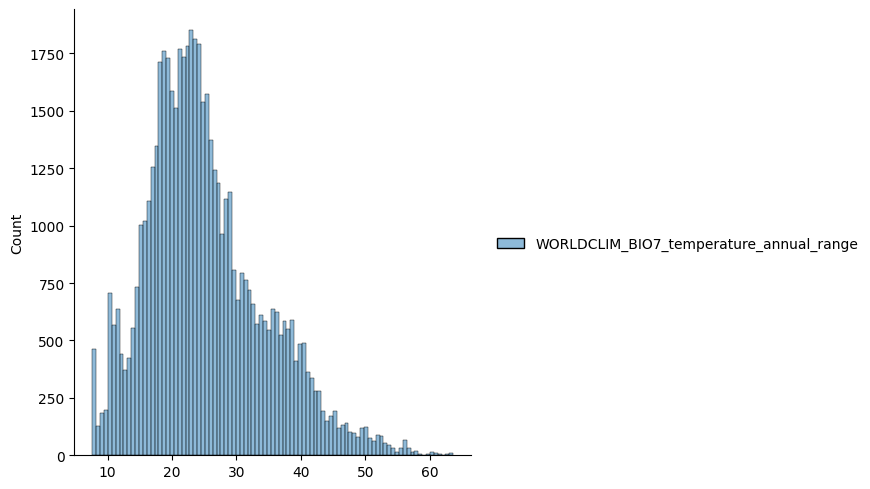

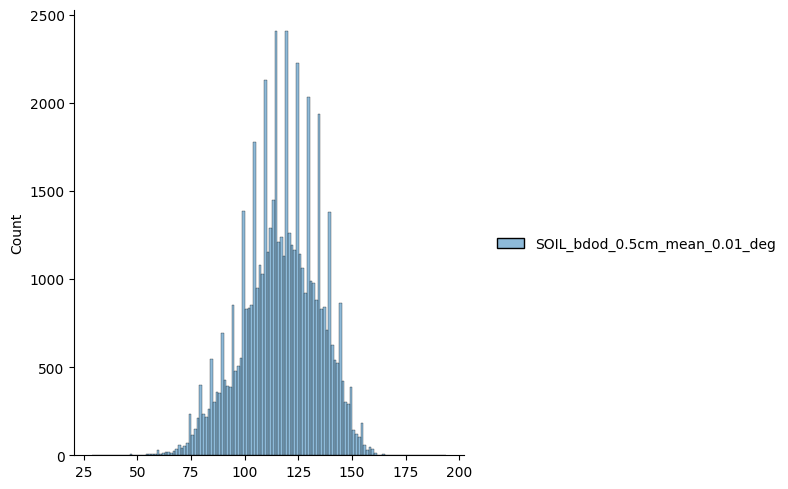

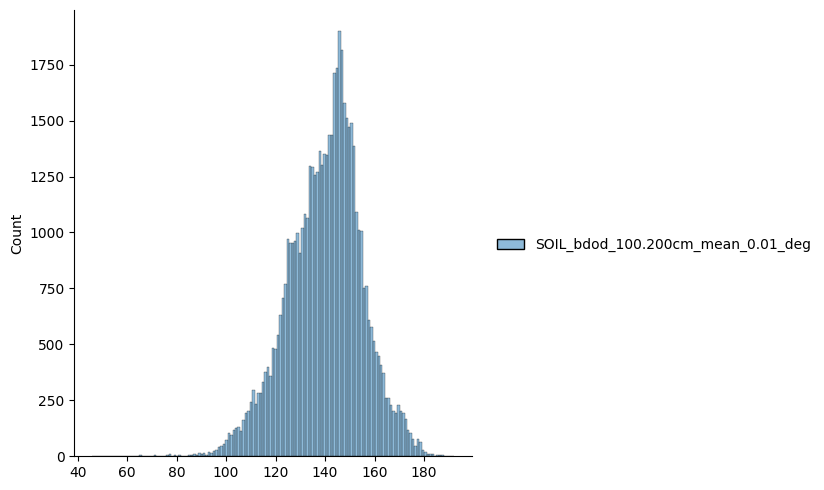

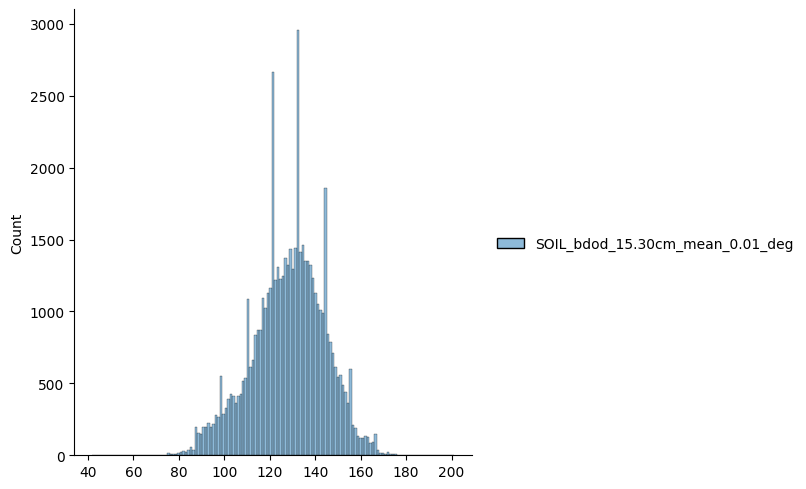

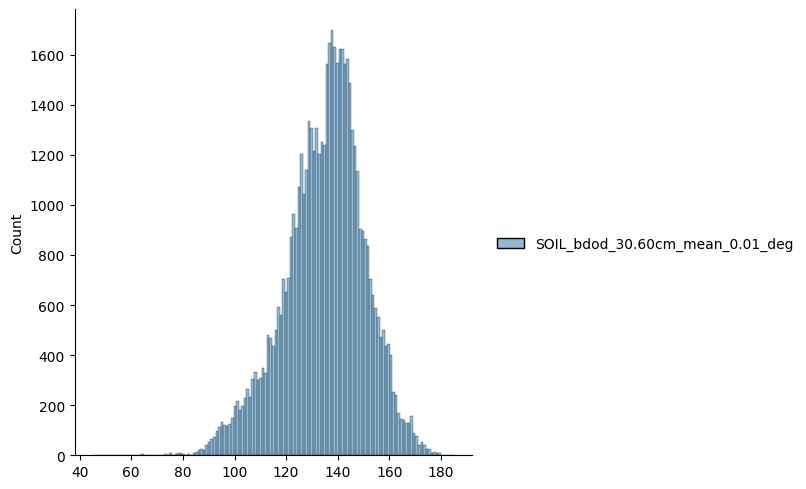

In [33]:
for i in range (10):

  data =   pd.DataFrame(train_df[metadata_columns[i]])
  sns.displot(data)

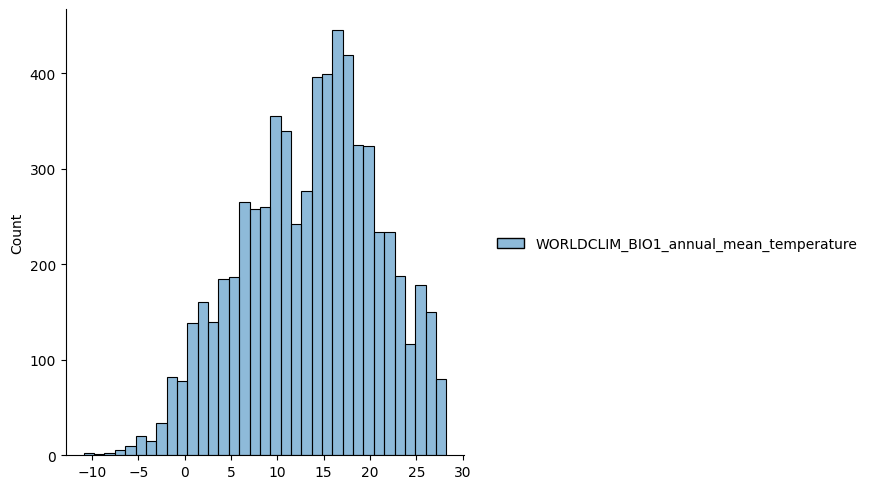

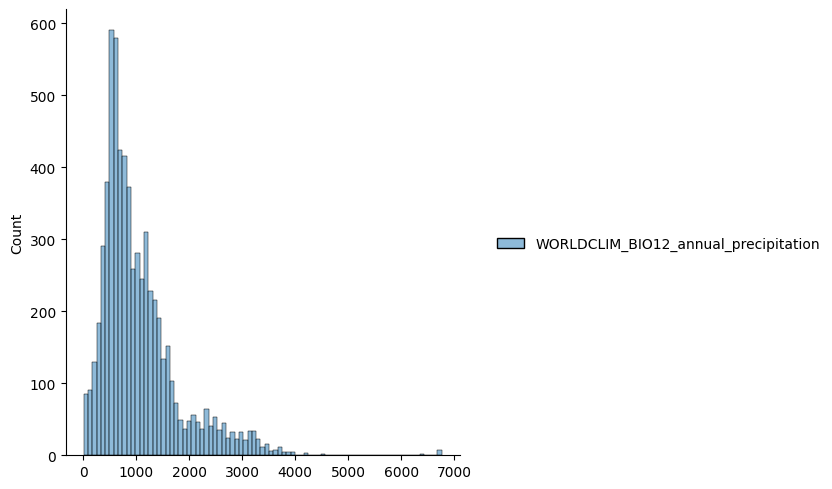

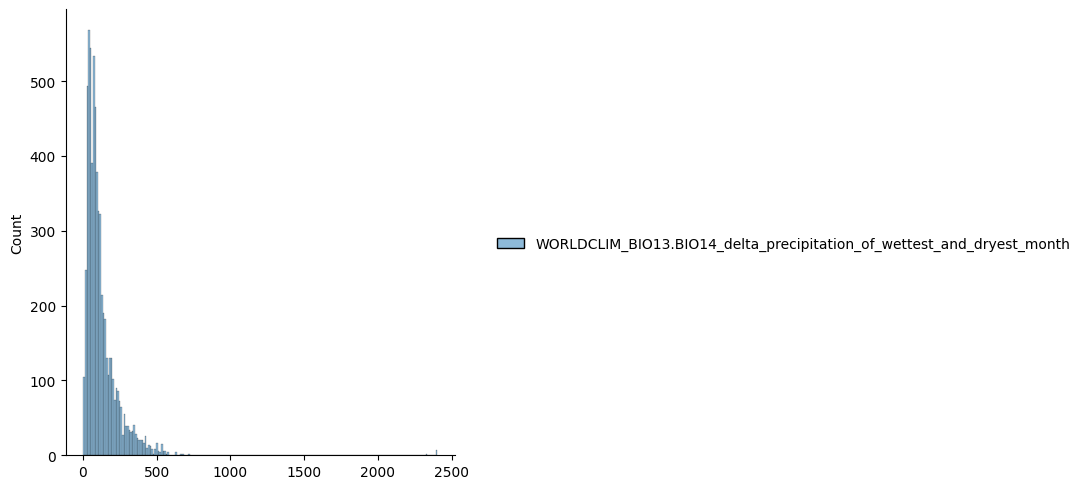

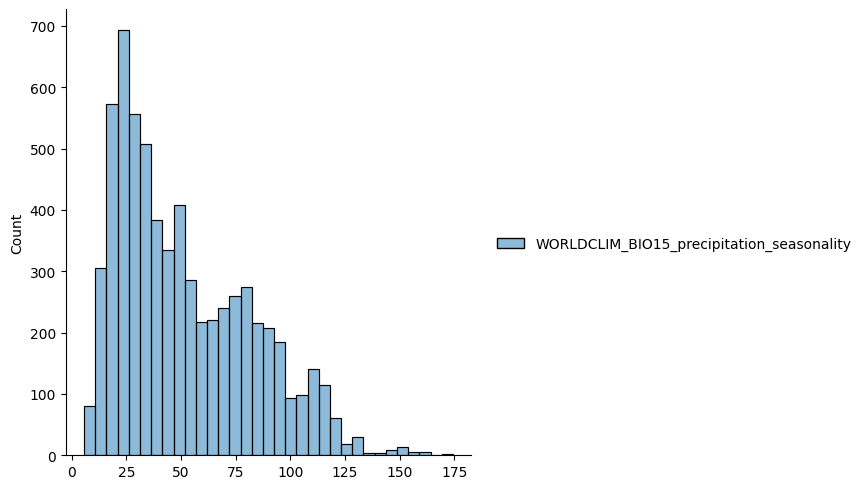

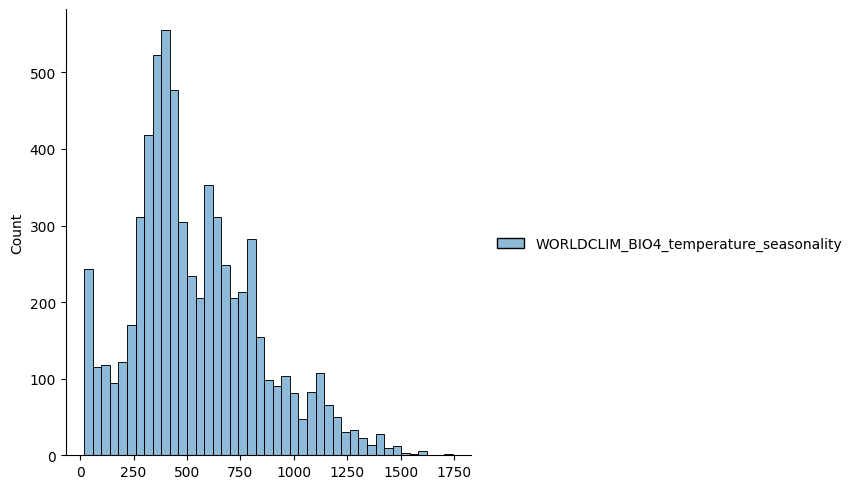

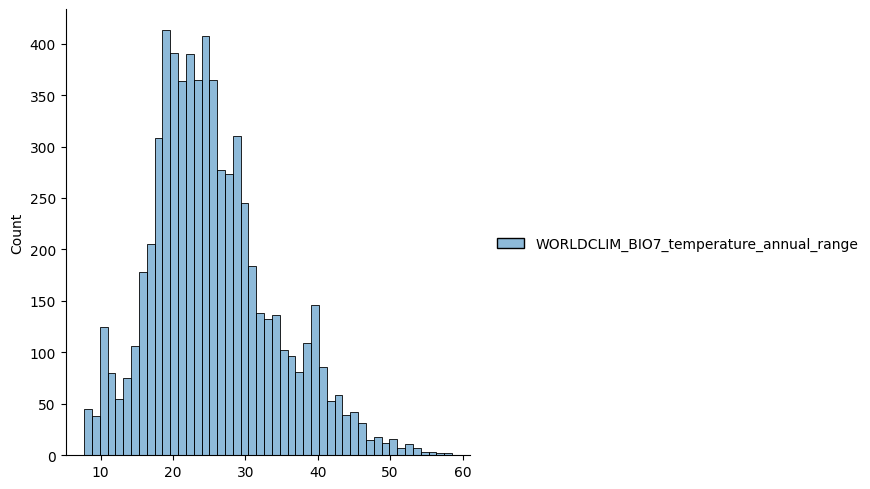

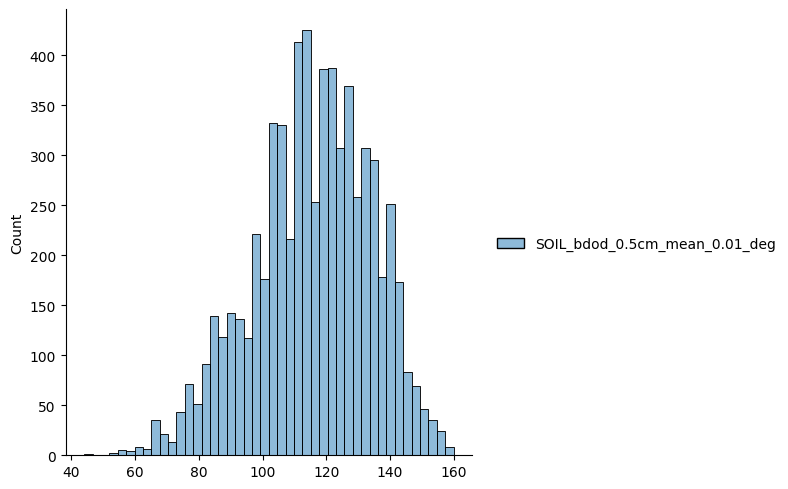

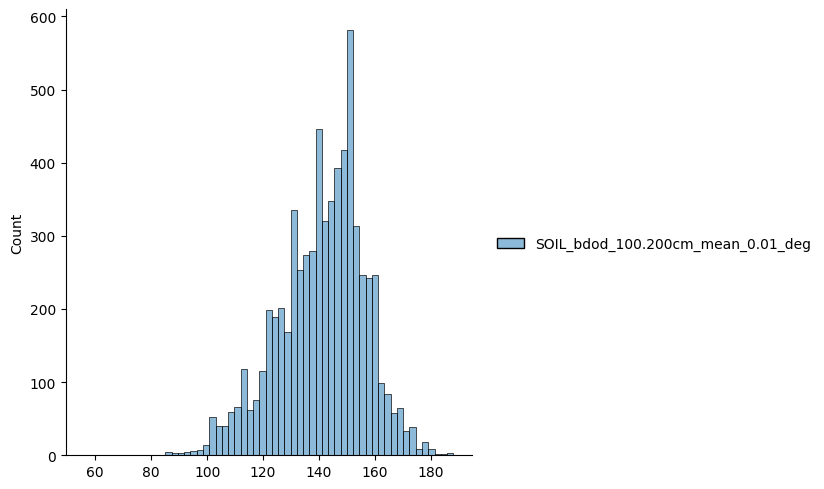

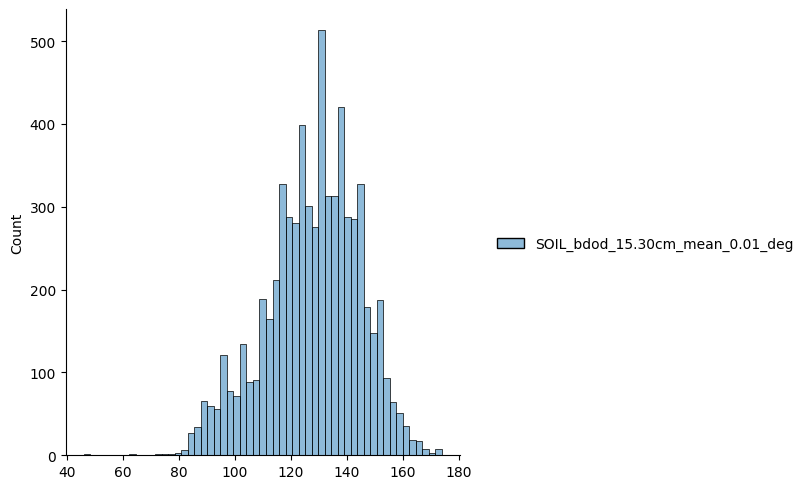

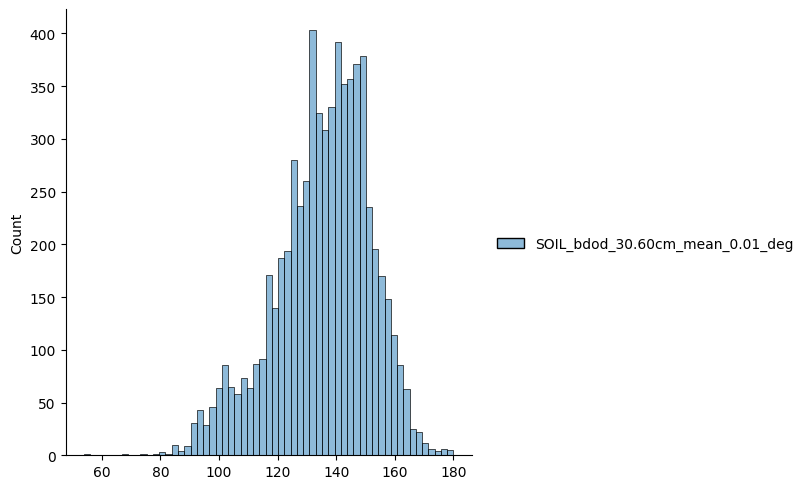

In [32]:
for i in range (10):

  data =   pd.DataFrame(test_df[metadata_columns[i]])
  sns.displot(data)

# Models and params

In [ ]:
opt_func = torch.optim.SGD
max_lr = 0.006431
weight_decay = 8.3145e-05
epochs = 20
optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
sched = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(test_loader))
load_checkpoint(checkpoint_path, model, optimizer, sched, device)

6

# Test ViT

In [ ]:
def test_model(model, test_loader):
    model.eval()
    all_outputs = []

    with torch.no_grad():
        for images, meta_data, targets in test_loader:
            outputs = model(images)
            all_outputs.append(outputs.cpu())  # Store outputs as tensors

    # Concatenate all output tensors and then convert to numpy
    all_outputs = torch.cat(all_outputs, dim=0).numpy()
    return all_outputs

In [ ]:
outputs = test_model(model, test_loader)

In [ ]:
len(outputs)

6545

In [ ]:
targets

['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']

In [ ]:
outputs

array([[0.6389949 , 1.0655923 , 0.32906255, 0.6354856 , 0.41900778,
        2.2938988 ],
       [0.40317383, 1.318068  , 0.1781491 , 0.28159872, 0.37377948,
        2.76972   ],
       [0.5674012 , 1.1326321 , 0.34388497, 0.8962259 , 0.45399752,
        2.5964427 ],
       ...,
       [0.507517  , 1.180442  , 0.5336745 , 1.2887654 , 0.41672373,
        3.5850115 ],
       [0.41632   , 1.2431322 , 0.09841451, 0.2833722 , 0.29311764,
        2.3477888 ],
       [0.5374074 , 1.1518642 , 1.0006262 , 1.8581455 , 0.3736815 ,
        3.5671701 ]], dtype=float32)

In [ ]:
df = pd.DataFrame(outputs, columns=targets)

In [ ]:
original_values = df


original_values['id'] = test_df['id']


result = original_values[['id', 'X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']]


result.columns = ['id', 'X4', 'X11', 'X18', 'X50', 'X26', 'X3112']


result

,id,X4,X11,X18,X50,X26,X3112
0,201238668,0.638995,1.065592,0.329063,0.419008,0.635486,2.293899
1,202310319,0.403174,1.318068,0.178149,0.373779,0.281599,2.769720
2,202604412,0.567401,1.132632,0.343885,0.453998,0.896226,2.596443
3,201353439,0.458402,1.377629,0.188064,0.312591,0.156797,2.911530
4,195351745,0.491293,1.157777,0.131888,0.402924,0.211293,2.327083
...,...,...,...,...,...,...,...
6540,195548469,0.502718,1.189912,0.202153,0.392544,0.523672,2.459735
6541,199261251,0.549397,1.212142,0.854980,0.391565,1.245052,3.648267
6542,203031744,0.507517,1.180442,0.533674,0.416724,1.288765,3.585011
6543,197736382,0.416320,1.243132,0.098415,0.293118,0.283372,2.347789


In [ ]:
result_log = result

In [ ]:
result_log[targets] = 10 ** result[targets] - 1

In [ ]:
result_log.to_csv('submission_ViT.csv',index=False)

In [53]:
vit_res = pd.read_csv('/content/submission_ViT_without_log.csv')

In [49]:
xgb_res = pd.read_csv('/content/submission_XGB_optimized2.csv')

In [55]:
xgb_res[xgb_res.columns[1:]] =  np.log10(xgb_res[xgb_res.columns[1:]] +1)

In [56]:
xgb_res

,id,X4,X11,X18,X50,X26,X3112
0,201238668,0.194660,1.083070,0.397045,0.387615,0.538210,2.339713
1,202310319,0.161557,1.272069,0.159114,0.394708,0.522887,2.631602
2,202604412,0.159242,1.198407,0.176168,0.423071,0.434465,2.602890
3,201353439,0.156441,1.339961,0.138582,0.351382,0.388207,2.791791
4,195351745,0.175435,1.036829,0.121342,0.401865,0.289490,2.353327
...,...,...,...,...,...,...,...
6540,195548469,0.217367,0.988215,0.456251,0.450969,0.862411,2.306158
6541,199261251,0.184908,1.205409,0.970712,0.391204,1.512803,3.739109
6542,203031744,0.162548,1.314180,0.303175,0.331934,0.530308,2.957808
6543,197736382,0.158005,1.280066,0.212551,0.374156,0.596496,2.755267


In [ ]:
result

,id,X4,X11,X18,X50,X26,X3112
0,201238668,0.638995,1.065592,0.329063,0.419008,0.635486,2.293899
1,202310319,0.403174,1.318068,0.178149,0.373779,0.281599,2.769720
2,202604412,0.567401,1.132632,0.343885,0.453998,0.896226,2.596443
3,201353439,0.458402,1.377629,0.188064,0.312591,0.156797,2.911530
4,195351745,0.491293,1.157777,0.131888,0.402924,0.211293,2.327083
...,...,...,...,...,...,...,...
6540,195548469,0.502718,1.189912,0.202153,0.392544,0.523672,2.459735
6541,199261251,0.549397,1.212142,0.854980,0.391565,1.245052,3.648267
6542,203031744,0.507517,1.180442,0.533674,0.416724,1.288765,3.585011
6543,197736382,0.416320,1.243132,0.098415,0.293118,0.283372,2.347789


In [76]:
combined_results_df = (0.9 * xgb_res[xgb_res.columns[1:]] + 0.1 * vit_res[xgb_res.columns[1:]])

In [77]:
combined_results_df['id'] = test_df['id']

In [78]:
combined_results_df = combined_results_df[['id', 'X4', 'X11', 'X18', 'X50', 'X26', 'X3112']]

In [79]:
for i in combined_results_df.columns[1:]:
  combined_results_df[i] = 10 ** combined_results_df[i] - 1

In [80]:
combined_results_df

,id,X4,X11,X18,X50,X26,X3112
0,201238668,0.734176,11.059301,1.456103,1.458978,2.531326,215.337324
1,202310319,0.533624,17.909023,0.448831,1.469533,2.153247,440.991726
2,202604412,0.585106,14.553553,0.559336,1.667863,2.024410,399.170268
3,201353439,0.536871,21.066192,0.391651,1.225887,1.317745,635.450819
4,195351745,0.610722,10.192407,0.325551,1.523310,0.912804,223.234461
...,...,...,...,...,...,...,...
6540,195548469,0.761578,9.194934,1.696754,1.786932,5.738095,208.659831
6541,199261251,0.664781,15.072455,8.102039,1.461727,29.621578,5369.623028
6542,203031744,0.574145,18.989680,1.119458,1.189845,3.037885,1047.402826
6543,197736382,0.526992,17.896129,0.589049,1.323016,2.674379,517.225789


In [81]:
combined_results_df.to_csv('comb_before_log_90_10.csv',index=False)

# Test_VGG

In [ ]:
checkpoint_path = '/content/drive/MyDrive/best_vgg_model.pth.tar'

In [ ]:
class PlantTraitsPretrainedVGG16(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = models.vgg16(pretrained=True)
        # Replace last layer
        self.network.classifier = nn.Sequential(
           nn.Linear(in_features=25088, out_features=4096, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.3, inplace=False),
           nn.Linear(in_features=4096, out_features=2048, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.3, inplace=False),
           nn.Linear(in_features=2048, out_features=6, bias=True),
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:

model =PlantTraitsPretrainedVGG16()

In [ ]:
opt_func = torch.optim.SGD
max_lr =  0.006387
weight_decay = 0.00009996
epochs = 20
optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
sched = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(test_loader))
load_checkpoint(checkpoint_path, model, optimizer, sched, device)

In [ ]:
outputs = test_model(model, test_loader)

In [ ]:
df = pd.DataFrame(outputs, columns=targets)